# Getting started with smart-geocubes

This notebook demonstrates how one could use the `smart-geocubes` package to download and cache specific regions from large scale geospatial datasets at the example of the ArcticDEM.

In [ ]:
import folium
from odc.geo.geobox import GeoBox
from stopuhr import stopuhr

import smart_geocubes

Let's start by creating an accessor to the ArcticDEM dataset. `smart-geocubes` provides the 32m resolution mosaic of the ArcticDEM dataset, along with some other datasets.

In [ ]:
accessor = smart_geocubes.ArcticDEM32m("datacubes/arcticdem_32m.icechunk")
accessor

ArcticDEM32m(GeoBox(Shape2d(x=231256, y=234381), Anchor[-4000096.0 - 4100096.0], EPSG:3413), ['dem', 'datamask'])

This didn't do much yet. Let's define an region of interest with an ODC-GeoBox in eastern russia.

## First region

In [3]:
roi = GeoBox.from_bbox((150, 65, 151, 65.5), shape=(1000, 1000))
roi.explore()

Now let's load the data. We measure the time with the `stopuhr` package, which provides a very convinient contextmanager for timing code blocks.

> Note: This may take a while (up to 10 minutes), since the data is downloaded from the ArcticDEM STAC API.

In [4]:
with stopuhr("Loading ArcticDEM at ROI"):
    arcticdem_at_roi = accessor.load(roi, create=True)
print(arcticdem_at_roi)

Loading ArcticDEM at ROI took 109.95s
<xarray.Dataset> Size: 20MB
Dimensions:      (y: 2110, x: 1908)
Coordinates:
  * y            (y) float64 17kB 2.657e+06 2.657e+06 ... 2.589e+06 2.589e+06
    spatial_ref  int32 4B 3413
  * x            (x) float64 15kB -7.581e+05 -7.581e+05 ... -6.971e+05
Data variables:
    dem          (y, x) float32 16MB 103.4 103.6 103.8 ... 79.65 79.78 79.67
    datamask     (y, x) bool 4MB True True True True ... True True True True
Attributes:
    title:         ArcticDEM32m
    loaded_tiles:  ['67_33_32m_v4.1', '66_34_32m_v4.1', '66_33_32m_v4.1', '67...


It took a while, but now we have the data downloaded and cached. Hence, opening the same region the next time will be much faster.

Now let's visualize what we got.

In [5]:
m = roi.explore()
arcticdem_at_roi["dem"].odc.explore(map=m)
m

### Reprojection

Our data covers the region we defined, but it does not fit perfectly to our specified region.
This is because we specified our region in another coordinate reference system (CRS) than the data is stored in.
`smart-geocubes` will always return the data in the CRS of the dataset, which is EPSG:3413 for ArcticDEM.
If we want to fit the data to our region, we need to reproject it manually, e.g. using `odc.geo`:

In [6]:
arcticdem_at_roi_reprojected = arcticdem_at_roi.odc.reproject(roi)

m = roi.explore()
arcticdem_at_roi_reprojected["dem"].odc.explore(map=m)
m

## Datacube State

As mentioned earlier, `smart-geocubes` cached the downloaded data.
To be exact, it stored it in a `zarr` datacube backed an `icechunk` store, located in the `"datacubes/arcticdem_32m.icechunk"` folder we specified earlier at the creation of our accessor.
This datacube will be filled up the more regions we download.
We can visualize how much of the datacube is already filled:

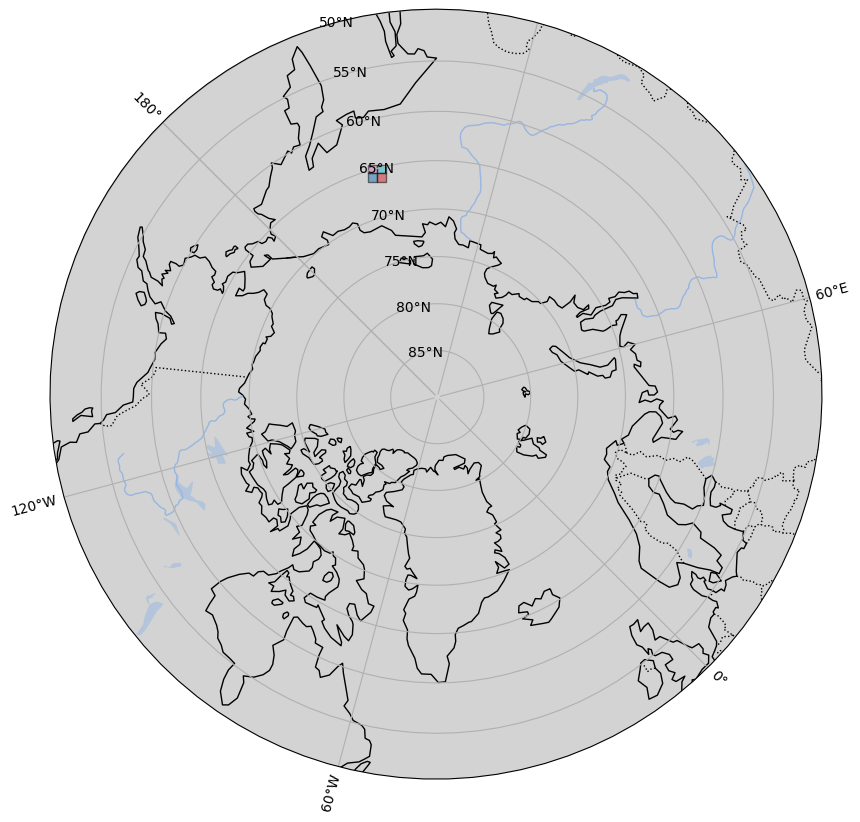

In [7]:
accessor.visualize_state();

We can see that the datacube is already filled with four tiles.
That means that our region of interest overlaps with four tiles of the ArcticDEM dataset.
Let us check this theory:

In [8]:
m = accessor.current_state().explore()
roi.explore(map=m)
m

Seems to be correct.

## Second region

Let's load a different region of interest, located just next to the previous one:

In [9]:
second_roi = GeoBox.from_bbox((150.5, 65, 151.5, 65.5), shape=(1000, 1000))
second_roi.explore()

In [ ]:
with stopuhr("Loading ArcticDEM at second ROI"):
    arcticdem_at_second_roi = accessor.load(second_roi)
print(arcticdem_at_second_roi)

Loading ArcticDEM at second ROI took 0.24s
<xarray.Dataset> Size: 20MB
Dimensions:      (x: 1919, y: 2119)
Coordinates:
    spatial_ref  int32 4B 3413
  * x            (x) float64 15kB -7.812e+05 -7.811e+05 ... -7.198e+05
  * y            (y) float64 17kB 2.65e+06 2.65e+06 ... 2.583e+06 2.583e+06
Data variables:
    datamask     (y, x) bool 4MB False False False False ... True True True True
    dem          (y, x) float32 16MB 95.91 95.91 95.91 ... 54.34 54.11 54.14
Attributes:
    title:         ArcticDEM32m
    loaded_tiles:  ['67_33_32m_v4.1', '66_34_32m_v4.1', '66_33_32m_v4.1', '67...


Wow, this was fast!
Because this region also overlaps with the tiles we already downloaded before, `smart-geocubes` just opened the existing tiles from the cache.

Let's visualize all together (try to play with the layer control on the top right):

In [11]:
m = roi.explore(name="First ROI", grid_lines=False)
second_roi.explore(map=m, name="Second ROI", grid_lines=False)
arcticdem_at_roi["dem"].odc.explore(map=m, name="DEM at first ROI")
arcticdem_at_second_roi["dem"].odc.explore(map=m, name="DEM at second ROI")
accessor.current_state().explore(m=m, name="Already loaded tiles")
folium.LayerControl().add_to(m)
m

## Third region

What happens when we want to load a third region of interest, which only partially overlaps with the tiles we already downloaded?

In [ ]:
third_roi = GeoBox.from_bbox((151, 65, 152, 65.5), shape=(1000, 1000))
with stopuhr("Loading ArcticDEM at third ROI"):
    arcticdem_at_third_roi = accessor.load(third_roi)
print(arcticdem_at_third_roi)

Loading ArcticDEM at third ROI took 67.40s
<xarray.Dataset> Size: 21MB
Dimensions:      (x: 1930, y: 2126)
Coordinates:
    spatial_ref  int32 4B 3413
  * x            (x) float64 15kB -8.041e+05 -8.041e+05 ... -7.424e+05
  * y            (y) float64 17kB 2.644e+06 2.644e+06 ... 2.576e+06 2.576e+06
Data variables:
    datamask     (y, x) bool 4MB True True True True ... True True True True
    dem          (y, x) float32 16MB 89.64 89.88 90.26 ... 46.83 46.66 46.63
Attributes:
    title:         ArcticDEM32m
    loaded_tiles:  ['67_33_32m_v4.1', '66_34_32m_v4.1', '66_33_32m_v4.1', '67...


It again took a while, but only half as long as the first time.
This is because this region overlaps with four tiles, two of which we already downloaded.
Hence, only two new tiles need to be downloaded.
Let's visualize the new state of the datacube:

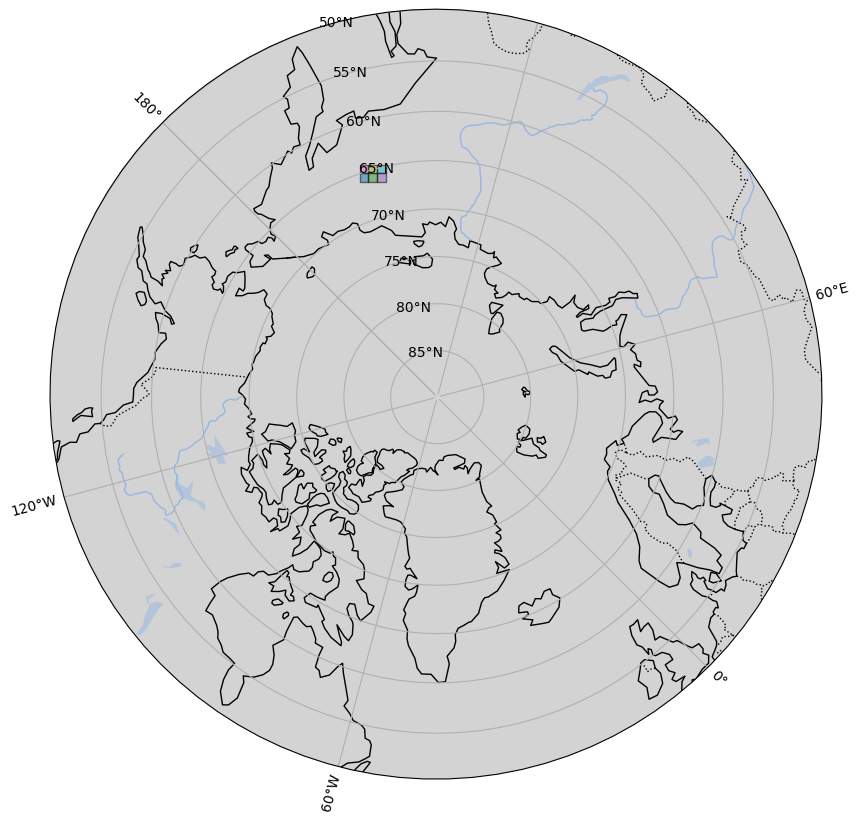

In [13]:
accessor.visualize_state();

We can see that two new tiles were added to the datacube, making it a total of six tiles.

Rerunning this notebook would not result in the same behavior: The load times would be significantly faster, since the data is already cached.